# Breweries, Beer, and Breviews: Unraveling the Global Beer Preferences
## Introduction

## Repository structure




## Include Libraries and initial settings
### Import all the libraries

In [1]:
# Import all the libraries
import pandas as pd

# Shutdown FutureWarning and UserWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Define the folder
FOLDER = 'data/processed/'
SAVING_FOLDER = 'docs/plots/'

### Load and filter the data
#### Load the data

In [2]:
df_beers = pd.read_parquet(FOLDER + 'beers.pq')
df_breweries = pd.read_parquet(FOLDER + 'breweries.pq')
df_users = pd.read_parquet(FOLDER + 'users.pq')
df_ratings_no_text = pd.read_parquet(FOLDER + 'ratings_no_text.pq')

## Data presentation
This section provides an overview of the dataset, which has been carefully cleaned and is nearly ready for analysis. We will summarize the data, display the first few rows, and describe the data types of the columns. For columns that are not self-explanatory, a brief description is included. <br><br>
Let's begin our analysis with the beers.

In [3]:
df_beers.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,abv
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,4.6
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,4.2
5,380930,Ards Bittles Christmas,13538,Ards Brewing Co.,Bitter,4.2
6,234108,Ards Bittles Citra Autumn Ale,13538,Ards Brewing Co.,American Pale Ale,5.1
7,396830,Ards Cardy Man,13538,Ards Brewing Co.,Stout,4.2


In [4]:
format_numeric_values = lambda x: f"{x:,.0f}"
print(f"In the platform there are {format_numeric_values(df_beers.shape[0])} different beers")

In the platform there are 314,242 different beers


Now let's take a look at the breweries.

In [5]:
df_breweries.head(5)

,brewery_id,brewery_name,country_brewery,state_brewery
1,13538,Ards Brewing Co.,United Kingdom,None
2,22304,Barrahooley Craft Brewery,United Kingdom,None
3,22818,Boundary,United Kingdom,None
4,24297,Brewbot Belfast,United Kingdom,None
5,27006,Bullhouse Brewing Company,United Kingdom,None


We have chosen, to ease the analysis processes, to split the location into two columns:
- One for the country.
- A separate column for US states.

This split was specifically applied to the US because it has a large number of users and breweries and combining all states into a single "US" category would have obscured important insights in some analysis (even if we are going to consider US as a single entity in some analysis). Additionally, the size and population of many US states are comparable to those of entire countries. This approach was not extended to other countries due to the lack of state-level data for them. <br><br>
The same choice has been made for all the location columns.

In [6]:
print(f"In the platform there are {format_numeric_values(df_breweries.shape[0])} different breweries")

In the platform there are 19,670 different breweries


Let's now add the location columns to the beers dataset

In [7]:
df_beers = df_beers.join(df_breweries[['brewery_id', 'country_brewery', 'state_brewery']].set_index('brewery_id'), on='brewery_id').rename(columns={'country_brewery': 'country_beer', 'state_brewery': 'state_beer'})
df_beers.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,abv,country_beer,state_beer
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,4.6,United Kingdom,None
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,4.2,United Kingdom,None
5,380930,Ards Bittles Christmas,13538,Ards Brewing Co.,Bitter,4.2,United Kingdom,None
6,234108,Ards Bittles Citra Autumn Ale,13538,Ards Brewing Co.,American Pale Ale,5.1,United Kingdom,None
7,396830,Ards Cardy Man,13538,Ards Brewing Co.,Stout,4.2,United Kingdom,None


Let's go back to analyze our data with the users dataset now.

In [8]:
df_users.head(5)

,user_id,user_name,joined,country_user,state_user
0,175852,Manslow,2012-05-20 10:00:00,Poland,None
2,288889,Sibarh,2013-11-16 11:00:00,Poland,None
3,250510,fombe89,2013-03-22 11:00:00,Spain,None
4,122778,kevnic2008,2011-02-02 11:00:00,Germany,None
5,227834,Beerhunter111,2012-11-12 11:00:00,Germany,None


In [9]:
print(f"In the platform there are {format_numeric_values(df_users.shape[0])} different users")

In the platform there are 46,993 different users


And finally let's have a look at the ratings dataset.

In [10]:
df_ratings_no_text.head(5)

,date,beer_id,user_id,brewery_id,abv,style,rating,mouthfeel,taste,appearance,aroma,overall,year,brewery_name,country_brewery,state_brewery,country_user,state_user
38,2015-04-16 12:00:00,155699,151109,13538,4.6,Stout,3.7,2.0,8.0,3.0,7.0,17.0,2015,Ards Brewing Co.,United Kingdom,None,Ireland,None
41,2013-10-01 12:00:00,155699,224156,13538,4.6,Stout,4.0,3.0,5.0,5.0,8.0,19.0,2013,Ards Brewing Co.,United Kingdom,None,United Kingdom,None
42,2013-06-18 12:00:00,155699,88501,13538,4.6,Stout,3.6,4.0,7.0,4.0,7.0,14.0,2013,Ards Brewing Co.,United Kingdom,None,New Zealand,None
43,2011-11-17 12:00:00,155699,128086,13538,4.6,Stout,4.0,5.0,7.0,5.0,7.0,16.0,2011,Ards Brewing Co.,United Kingdom,None,United Kingdom,None
44,2013-11-23 12:00:00,239097,128086,13538,4.2,Golden Ale/Blond Ale,3.0,3.0,5.0,4.0,6.0,12.0,2013,Ards Brewing Co.,United Kingdom,None,United Kingdom,None


In [11]:
print(f"In the platform there are {format_numeric_values(df_ratings_no_text.shape[0])} different reviews")

In the platform there are 6,424,384 different reviews


The ratings comes from the [RateBeer](ratebeer.com) website which has the following rating system (source [RateBeer Scores](https://www.ratebeer.com/our-scores)):
- <b>Aroma</b>: The smell of the beer
- <b>Appearance</b>: The color, clarity, head and visual carbonation of this beer.
- <b>Taste</b>: The flavors in this beer, thinking about the palate, bitterness and finish.
- <b>Mouthfeel</b>: The body of the beer, carbonation and astringency.
- <b>Overall</b>: The overall characteristics and your personal experience of the beer.

Appearance and Mouthfeel are each scored out of 5. Aroma and Taste are scored out of 10. While Overall is scored out of 20. These all combine to give the beer a total score out of 50 (the <b>Rating</b> column), which is then divided and displayed as a score out of 5 for each rating. <br>
The fact that the <b>Rating</b> column is the sum of the other columns is important to keep in mind when analyzing the data in particular when doing correlation analysis. No normalization has been performed at this stage.<br><br>
The country of the brewery is computed from the <code>brewery</code> dataset while the country of the user is computed from the <code>user</code> dataset.

In [12]:
print(f"In the platform there are {format_numeric_values(df_ratings_no_text.shape[0])} different ratings")
print(f"The first rating was made on {df_ratings_no_text['date'].min()}")
print(f"The last rating was made on {df_ratings_no_text['date'].max()}")

In the platform there are 6,424,384 different ratings
The first rating was made on 2002-01-01 12:00:00
The last rating was made on 2016-12-31 12:00:00


We see that our dataset ends and begin at the beginning of January 2002 and ends at the end of December 2016 with a total of 6,424,384 different ratings. Some of the ratings have been removed to ensure consistent results. <br>
We indeed observed that by considering earlier and later ratings the results for those years were not consistent or reasonable mainly because:
- The first year that where we have data from the beginning of January is 2001 but the ratings on this year are significantly lower than the rest and doesn't follow the trend of the other years.
- The last year that ends at the end of December is 2016 because on 2017 we have not data for the second half of the year. The number of ratings in this year indeed are completely off if compared with the other years.

Now that we had an overview of the data let's have a look at the geographical distribution of our data in the world.

In [13]:
# Include all the coee needed for the data presentation
from src.processing import presentation as pr
data_presentation = pr.DataPresentation(df_beers, df_breweries, df_users, df_ratings_no_text, f'{SAVING_FOLDER}/data_presentation/')

In [14]:
# Plot the aggregated spatial data
data_presentation.plot_spatial_data()

In [15]:
# Plot the top 5 for each category
data_presentation.plot_top_5()

We see that the data are spread in all the world, with a higher concentration in the United States, if considered as a whole. If we consider the single states of the United States then we have that Enland, Germany, Belgium and Canada are very active together with California that is the most active state in the United States. <br><br>
We can say that while the dataset is more biased towards united states we'll show in the further analysis that by considering the single states and not only the entire country we can highlight some interesting differences within the United States.

And finally let's review the temporal distribution of the data.

In [16]:
# Plot the number of ratings over time
data_presentation.plot_number_of_ratings_over_time()

In [17]:
# Plot the number of users that have joined the platform over time
data_presentation.plot_number_of_users_over_time()

We see that the number of ratings peak in 2015 while the number of new users peak in 2012 with a decline after that year.

## Global ratings analysis
In this section we are going to analyze the preferences of the users of the platform in a general way.
### General study of the distribution of the ratings
First of all we are going to study how the grades are distributed in the different categories. This will help us understand if there are specific bias towards some categories and whether the users are more or less demanding in some categories.

In [18]:
# Include all the code needed for the global ratings analysis
from src.processing import global_analysis as gp
global_analysis = gp.GlobalAnalysis(df_beers, df_breweries, df_users, df_ratings_no_text, SAVING_FOLDER + 'global_analysis/')

In [19]:
# Display the ratings distribution
global_analysis.display_ratings_distribution()

Before doing any conclusion also let's compute some key metrics for each category.

In [20]:
# Plot the different statistics of the ratings distribution
global_analysis.display_ratings_statistics()

Statistics of the ratings 
 
 
 Rating 
 Mean 
 Std 
 Median 
 Skewness 
 Kurtosis 
 Can reject H0 (95%) 
 
 
 
 
 mouthfeel 
 3.27 
 0.79 
 3.0 
 -0.19 
 0.25 
 True 
 
 
 taste 
 6.48 
 1.53 
 7.0 
 -0.79 
 1.01 
 True 
 
 
 appearance 
 3.43 
 0.77 
 3.0 
 -0.15 
 0.26 
 True 
 
 
 aroma 
 6.4 
 1.53 
 7.0 
 -0.77 
 1.0 
 True 
 
 
 overall 
 13.18 
 3.14 
 14.0 
 -0.99 
 1.4 
 True 
 
 
 rating 
 3.28 
 0.68 
 3.4 
 -0.92 
 1.42 
 True

We observe multiple interesting aspects:
- **Central Tendency Bias:**  
  All the ratings have a mean and median close to the center of the rating scale. This suggests users exhibit a central tendency bias, where they avoid extreme judgments and rate items near the middle of the scale. However, the Shapiro-Wilk test at 95% confidence indicates the data are not normally distributed, as also evident from the distribution plots.  

- **Category-specific Observations:**  
  While the mean and median are generally close to the center of the rating scale, there are notable differences, both numerically and visually:  

  - **Mouthfeel and Appearance:**  
    - The mean is slightly higher than the median, and skewness is lower compared to other categories.  
    - This suggests users are more demanding in these categories, leading to generally lower ratings.  
    - The subjectivity and difficulty in evaluating these attributes could also play a role. For instance, what constitutes a "5-star" mouthfeel is often ambiguous.  

  - **Taste and Aroma:**  
    - The median is slightly higher than the mean, indicating users favor these categories and tend to give them higher ratings.  
    - This suggests users genuinely enjoy these aspects, resulting in more favorable evaluations.  

  - **Overall Rating:**  
    - The overall score leans toward the higher end of the scale, potentially influenced by taste and aroma ratings.  
    - This warrants further investigation in future analyses.  

- **Possible presence of a social bias**
  The fact that you usually drink beers in social and convivial contexts could lead to a social bias in the ratings that could push the ratings towards the higher values. An "average" beer could be rated higher than it might be because the user was in a good mood or in a good company, which made the user enjoy the beer more than it would have been in a different context.

### Correlation between the ratings attributes
Here we are gonna analyze the correlation between the ratings attributes given by the users. In this section we won't consider the rating but rather the overall score as an overall rate of the experience. This is reasonable since:
- The overall is used to evaluate in general the experience of the beer
- The rating is computed from the other parameters so studing the correlation of the parameters with respect to it has little to no significance.

In [21]:
# Display the correlation matrix
global_analysis.plot_correlation_matrix()

We see that taste and aroma show the highest correlations with overall beer ratings, at 0.86 and 0.77, respectively. These attributes dominate the beer experience given their impact on the overall flavor profile.

Appearance and palate, on the other hand, have moderate correlations with overall beer ratings, at 0.50 and 0.66, respectively. The lower correlation, compared with the one of taste and aroma, suggests that these attributes play a secondary role in the overall experience, either for the complexity of the evaluation or for the less significance in the overall experience.

Alcohol by volume (ABV) has the lowest correlation overall (with a correlation of 0.37 with the overall ratings) even if it's still significant. This suggests that there is some link between the ABV and the users preferences that we are going to explore further in the next sections.

We see that there is a strong relation between the different parameters and the overall score. Can we use them to predict wether or not the user will enjoy the beer?

In [22]:
results, r_squared, rmse = global_analysis.regression_analysis(df_ratings_no_text)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                 4.379e+06
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:59:53   Log-Likelihood:            -9.3520e+06
No. Observations:             5137784   AIC:                         1.870e+07
Df Residuals:                 5137779   BIC:                         1.870e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1760      0.001      2e+04      0.0

In [23]:
print(f"The R-squared value at test is {r_squared:.4f}")
print(f"The RMSE value at test is {rmse:.2f}")

The R-squared value at test is 0.7732
The RMSE value at test is 1.50


It seems we can do this!</br><br>
From the linear regression model we can clearly see that the four parameters are significant in predicting the overall experience of an user and whether or not one will like the beer. We see that approximately 77% of the variance is explained by the model with a test set and that the RMSE is quite low, approximately 1.50, which is not significant in a scale with a granularity of 1. <br>
From the p value we see that all the parameters are significant in the prediction of the overall grade (the p value for all of them is almost zero). <br>
We see that taste has almost double the impact on the overall experience than aroma, with the first one that has a coefficient of <b>1.7843</b> vs a coefficient of <b>0.7184</b> for the second parameter. We see that the appearance and the mouthfeel have a much lower impact than the others (respectively <b>0.4159</b> and <b>0.1296</b>). <br><br>
From these results we have a significant insight: if user does't like the taste of a beer than they'll likely won't like the beer at all. The phenomenon where one attribute significantly affect the overall impression of a product is also known as the <b>halo effect</b>. This is a cognitive bias where the perception of one quality of a product influences the perception of other qualities of the product. In this case, the taste of the beer is the quality that influences the perception of the other qualities of the beer.

### Rating in the different countries
Here we are going to see which are the favourite beer locations in the world. We are going to consider the rating here to have a metric that summarize all the other parameters, given that now we know how they influence the overall experience and in general how impactful each of them on user preferences.

In [24]:
# Display the ratings in the world map
average_rating_no_US, average_rating_US = global_analysis.ratings_world_map()

In [25]:
average_rating = pd.concat([average_rating_no_US, average_rating_US]).sort_values('count', ascending=False)
average_rating.head(10)

,location,count
1,Alaska,3.629238
35,Oklahoma,3.618523
4,California,3.601744
34,Ohio,3.551829
12,Illinois,3.546681
36,Oregon,3.532074
47,Washington DC,3.512826
8,Belgium,3.498091
28,New Hampshire,3.488963
9,Georgia,3.487447


In [26]:
average_rating = pd.concat([average_rating_no_US, average_rating_US]).sort_values('count', ascending=True)
average_rating.head(10)

,location,count
81,Nicaragua,1.787751
41,Guatemala,1.818750
29,El Salvador,1.823953
22,Cuba,1.908679
28,Egypt,1.913043
113,Venezuela,1.921269
109,Uganda,1.922050
76,Myanmar,1.945098
104,Tanzania,1.976498
26,Dominican Republic,1.978745


We see that the ratings are in general higher in the United States than in the rest of the world. We see indeed that the top 5 countries in terms of average ratings are all from US and we need to get to the 8th place to find a country outside the states. <br>
We see that most european countries have a rating that is slightly above the middle of the scale, with Belgium that is the highest rated country of Europe followed by Norway and Englang. Surprisingly we see that Germany beers are liked slightly less the other Center Europe countries. <br>
We see that in general the beers outside of Europe are liked way less than European or US beers with an average that is much lower than the other countries with the worst ones that have an average rating that is below 2.

### Rating evolution over time in the different countries

In [27]:
# Plot the rating evolution over time
global_analysis.ratings_evolution_map()

In [28]:
# Plot the mean and median evolution of the different ratings over time
global_analysis.plot_median_mean_ratings_evolution()

We see that overall there is an increase in the ratings over time with an increase of all key features. We see that aroma and taste over time had an increase in the overall rating of almost 1 point with a clear shift towards the higher values for all of them (all of them had an increase of one unit of the median, meaning that over time most users rate higher these parameters). This means that over time users are more and more satisfied with the beers they drink. <br><br>
Even so we see that appearance and mouthfeel have both very timid variations over time, meaning that these parameters are either less understood or they are less important in the overall experience of the beer. 

## ABV and style analysis
#### ABV analysis
In this section we'll continue by analyzing the popularity of ABV and style in the world and we'll also study how these have evolved over time.

In [29]:
# Import all the code needed to plot ABV related content
from src.processing import abv as abv
abv_pres = abv.ABV(df_beers, df_breweries, df_users, df_ratings_no_text, save_folder=SAVING_FOLDER + '/abv')

In [30]:
# Plot the ABV Vs Ratings plot
beer_ratings = abv_pres.plot_abv_vs_ratings()

In [31]:
# Plot the correlation between ABV and Ratings
abv_pres.plot_corr_abv_ratings(beer_ratings)

In [32]:
# Plot the average ABV over time
abv_pres.plot_abv_evolution()

In [33]:
abv_pres.plot_abv_evolution_map()

## Influence of location on beer preference

For many beer consumers it might make sense to look at where the beer is produced before having it. Some countries are known for their large beer cultures and might generally make better beer than others. To investigate this, we will first check for 'beer hubs', countries that are particularly known by others for having good beer. 

We will do this by creating a graph. Each country will have an outgoing edge to another country. The edge will be present only if the other country produces the foreign beer that is most reviewed in the other country. 

In other words, A->B only exists if B produces the most reviewed beer for A with the side constraint that A != B.

In [14]:
from src.processing import location_influence as li

nwp = li.NetworkPlot(df_ratings_no_text)
nwp.plot_location(width="100%", height="100%") # Height is ignored in pyvis, need to set it manually in the HTML

interactive_graph.html


To identify hubs numerically, we can print the in-degrees of each country:

In [15]:
nwp.print_in_degrees()

Node: Argentina, In-Degree: 1
Node: United States, In-Degree: 28
Node: Ascension Island, In-Degree: 0
Node: Australia, In-Degree: 1
Node: United Kingdom, In-Degree: 11
Node: Austria, In-Degree: 0
Node: Germany, In-Degree: 9
Node: Belarus, In-Degree: 0
Node: Russia, In-Degree: 1
Node: Belgium, In-Degree: 17
Node: Bermuda, In-Degree: 0
Node: Bolivia, In-Degree: 0
Node: Brazil, In-Degree: 0
Node: Bulgaria, In-Degree: 0
Node: Cambodia, In-Degree: 0
Node: Canada, In-Degree: 1
Node: Chile, In-Degree: 0
Node: China, In-Degree: 0
Node: Colombia, In-Degree: 0
Node: Croatia, In-Degree: 0
Node: Cyprus, In-Degree: 0
Node: Czech Republic, In-Degree: 1
Node: Denmark, In-Degree: 1
Node: Dominican Republic, In-Degree: 0
Node: Ecuador, In-Degree: 0
Node: El Salvador, In-Degree: 0
Node: Estonia, In-Degree: 0
Node: Faroe Islands, In-Degree: 0
Node: Finland, In-Degree: 0
Node: France, In-Degree: 0
Node: Greece, In-Degree: 0
Node: Greenland, In-Degree: 0
Node: Poland, In-Degree: 2
Node: Guam, In-Degree: 0


Now we can see that the USA, Belgium, UK and Germany are large hubs. These are indeed the countries we expect to see, as these have very large beer cultures and are very well-known all over the world. 

But it is also important to check whether all countries like local or foreign beers equally. Even though some countries might drink a lot of foreign beer, they may still have a preference for locally produced products. To investigate this, we can plot the top 10 countries that prefer foreign beers the most, and top 10 countries that like local beers the most. This plot looks as follows:

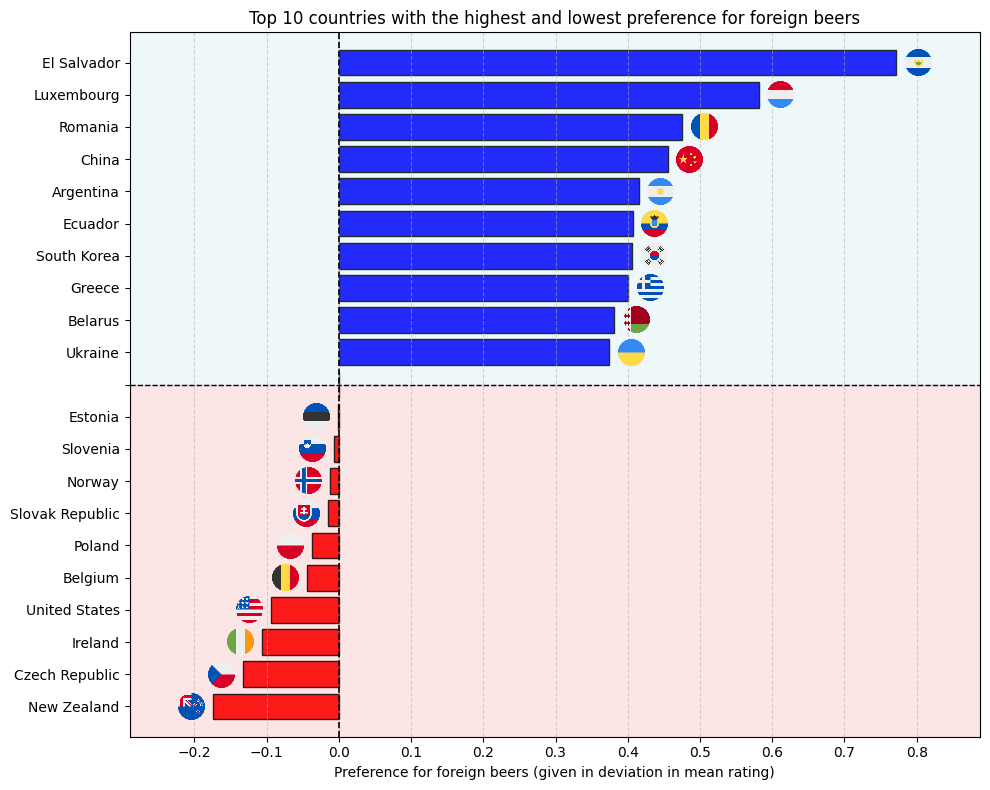

In [3]:
from src.processing import location_influence as li

mlp = li.MostLeastPlot(df_ratings_no_text, minThresh=100)
mlp.plot(n=10)

Here we see very logical results once again. Some countries that are very well-known for their beers have a large preference for local beers. These countries include Czechia, Ireland, the USA and Belgium. On the other side of the spectrum, we have countries that are not known for their beers but are very close to large hubs. El Salvador is quite close to the USA, Luxemberg is very close to Germany, Belgium and the UK and so forth.